In [1]:
# -*- coding: utf-8 -*-
###############################################################################

# This notebook implements the plots in the Chapter 5.1 of the paper.  
# https://arxiv.org/pdf/1007.1727v3.pdf

# Author: Haoran Zhao
# Email: hrzhao76 AT gmail.com
###############################################################################

In [2]:
from utils import *

# Figure 3(a)

100%|██████████| 4/4 [00:12<00:00,  3.14s/it]


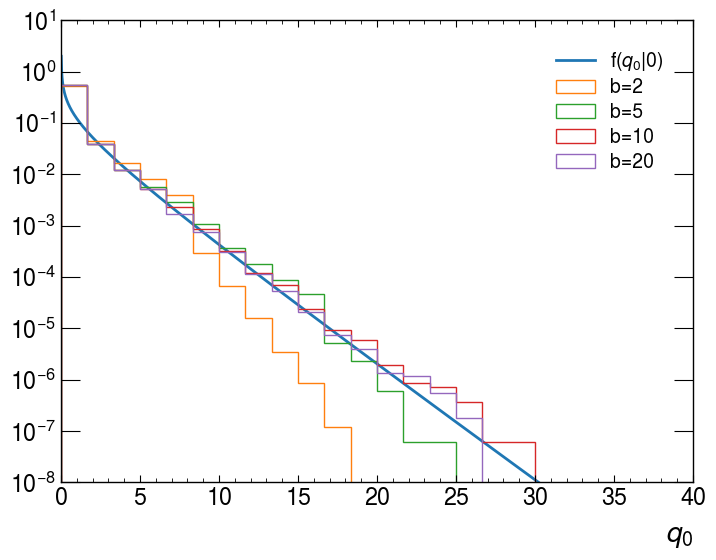

In [3]:
s = 10  # number of signal events
tau = 1 # scale factor, general unknown.

x_s = np.linspace(0.01, 40, 3001)

fig, ax = plt.subplots(figsize=(6, 6))
f_q0_x = f_q0(q0=x_s)
ax.plot(x_s, f_q0_x, label=r"f($q_0$|0)")
ax.set_yscale("log")
ax.set_ylim(1e-8, 10)
ax.set_yticks([10, 1] + [1 / 10**i for i in range(1, 9)])

ax.set_xlabel(r"$q_0$")


b_s = [2, 5, 10, 20]
mu = 0
N_trails = 10000000
for b in tqdm(b_s):
    n_s = stats.poisson.rvs(mu=mu * s + b, size=N_trails)
    m_s = stats.poisson.rvs(mu=tau * b, size=N_trails)
    q0_s = Get_q0(n=n_s, m=m_s, mu=mu, s=s)
    ax.hist(q0_s, bins=24, range=(0, 40), density=True, histtype="step", label=f"b={b}")

ax.legend()
plt.show()

# Figure 3(b)

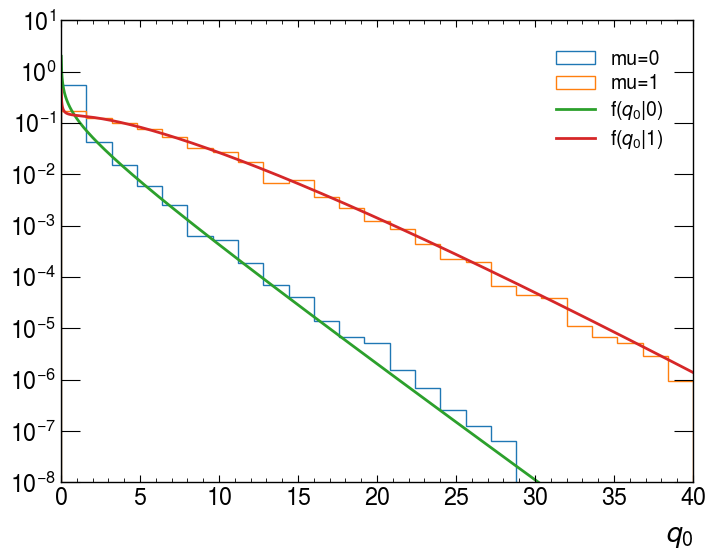

In [4]:
s = 10
b = 10
tau = 1
N_trails = 10000000

fig, ax = plt.subplots(figsize=(6, 6))
mu = 0
n_s = stats.poisson.rvs(mu=mu * s + b, size=N_trails)
m_s = stats.poisson.rvs(mu=tau * b, size=N_trails)

q0_s = Get_q0(n=n_s, m=m_s, mu=mu, s=s)
ax.hist(q0_s, bins=25, range=(0, 40), density=True, histtype="step", label=f"mu=0")

mu = 1
n_s = stats.poisson.rvs(mu=mu * s + b, size=N_trails)
m_s = stats.poisson.rvs(mu=tau * b, size=N_trails)
q0_1_s = Get_q0(n=n_s, m=m_s, mu=mu, s=s)
ax.hist(q0_1_s, bins=25, range=(0, 40), density=True, histtype="step", label=f"mu=1")


x_s = np.linspace(0.01, 40, 3001)

f_q0_x = f_q0(q0=x_s)
f_q0_muprime_x = f_q0_muprime(q0=x_s, mu_prime=1, sigma=calSigma_Asimov(mu_prime=1, s=10, b=10, mu=0))

ax.plot(x_s, f_q0_x, label=r"f($q_0$|0)")
ax.plot(x_s, f_q0_muprime_x, label=r"f($q_0$|1)")

ax.legend()
ax.set_yscale("log")
ax.set_ylim(1e-8, 10)
ax.set_yticks([10, 1] + [1 / 10**i for i in range(1, 9)])

ax.set_xlabel(r"$q_0$")
plt.show()

# Figure 4(a)

In [20]:
s = 10
tau = 1
N_trails = 10000000
b_s =  np.array([1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90])
mu = 0
q0_cut = 16
Z0_s = []
for b in b_s:
    n_s = stats.poisson.rvs(mu=mu * s + b, size=N_trails)
    m_s = stats.poisson.rvs(mu=tau * b, size=N_trails)
    q0_s = Get_q0(n=n_s, m=m_s, mu=mu, s=s)

    binContent, binEdges = np.histogram(q0_s,bins=np.linspace(0,40,41))
    
    # calculate the p-value above q0_cut
    Z0_s.append(calZ0(np.sum(binContent[q0_cut:]) / np.sum(binContent)))


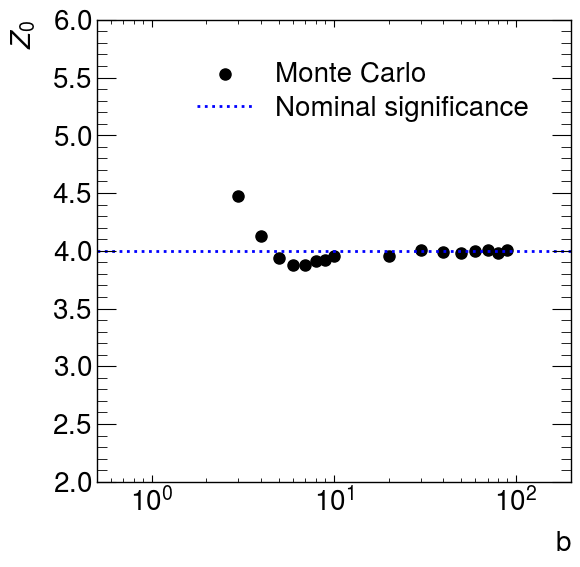

In [21]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.scatter(b_s, Z0_s,color = "black",label="Monte Carlo")
plt.axhline(y=4 , xmin=0, xmax = 1, linewidth = 2, linestyle = ":", color = "blue",label="Nominal significance")

plt.xlabel("b" , fontsize=20, horizontalalignment='right',x=1) 
plt.ylabel("$Z_0$", fontsize=20, horizontalalignment='right',y=1)


plt.xscale('log')
plt.xticks(fontsize=20)   # set x-ticks size
plt.yticks(fontsize=20)   # set y-ticks size 
plt.ylim((2,6))
plt.xlim((0.5,200))

plt.legend(loc="best",ncol=1,fontsize=20,frameon=False)#
plt.show()

# Figure 4(b)

In [45]:
s_s = np.array([1, 2, 5, 10, 20])
b_s =  np.array([1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90])

mu = 1
N_trails = 10000000

medians = dict.fromkeys(s_s)
for i, s in tqdm(enumerate(s_s)):
    medians[s] = []
    for j, b in enumerate(b_s):
        n_s = stats.poisson.rvs(mu=mu * s + b, size=N_trails)
        m_s = stats.poisson.rvs(mu=tau * b, size=N_trails)

        q0_s = Get_q0(n=n_s, m=m_s, mu=mu, s=s)
        medians[s].append(np.median(q0_s))


5it [04:48, 57.68s/it]


In [57]:
q0_Asimov = dict.fromkeys(s_s)
for i, s in tqdm(enumerate(s_s)):
    q0_Asimov[s] = []
    q0_Asimov[s].append(Get_q0(n=mu * s + np.linspace(1, 90, 90), m=tau * np.linspace(1, 90, 90), mu=mu, s=s))

5it [00:00, 3575.10it/s]


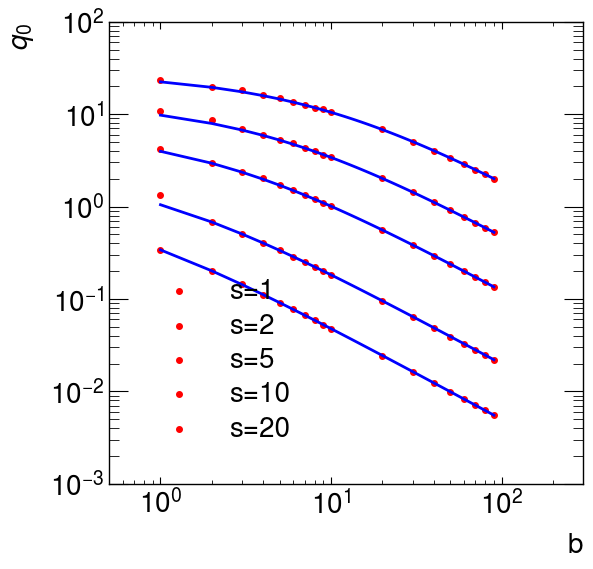

In [62]:
fig, ax = plt.subplots(figsize=(6,6)) 

for k, value in medians.items():
    ax.scatter(b_s, value, label=f"s={k}", marker='.', color="red")

for k, value in q0_Asimov.items():
    ax.plot(np.linspace(1, 90, 90), value[0], color="blue")
    
plt.xlabel("b" , fontsize=20, horizontalalignment='right',x=1) 
plt.ylabel("$q_0$", fontsize=20, horizontalalignment='right',y=1)


plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize=20)   # set x-ticks size
plt.yticks(fontsize=20)   # set y-ticks size 
plt.xlim((0.5,300))
plt.ylim((1E-3,1E+2))
plt.legend(loc="best",ncol=1,fontsize=20,frameon=False)#
plt.show()

# DeV 

In [5]:
calSigma_Asimov(mu_prime=1, s=10, b=10, mu=0)

0.5424872603903438

In [6]:
calSigma_Cov(s=10, b=10, tau=1, mu_prime=1, N_trails=10000000)

0.5477337688483788